In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data


In [2]:
# #load the data 

# dltr_df= get_data("DLTR", start_date="01/01/2014", end_date="08/23/2022", index_as_date = False, interval="1wk")
# dltr_df

dltr_df = pd.read_csv('DLTR.csv')


#This is the issue i was running into " EOL while scanning string literal"
#So this is they wasy that I had to do it. 

In [3]:
dltr_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-03,56.549999,56.919998,56.389999,56.570000,56.570000,1694200
1,2014-01-06,56.740002,57.410000,56.549999,56.759998,56.759998,2780000
2,2014-01-07,56.549999,56.939999,56.480000,56.590000,56.590000,2398200
3,2014-01-08,56.470001,56.709999,56.330002,56.639999,56.639999,1914300
4,2014-01-09,55.919998,56.910000,55.639999,56.430000,56.430000,3417000


In [4]:
#Inspect it 
print(dltr_df)

            Date        Open        High         Low       Close   Adj Close  \
0     2014-01-03   56.549999   56.919998   56.389999   56.570000   56.570000   
1     2014-01-06   56.740002   57.410000   56.549999   56.759998   56.759998   
2     2014-01-07   56.549999   56.939999   56.480000   56.590000   56.590000   
3     2014-01-08   56.470001   56.709999   56.330002   56.639999   56.639999   
4     2014-01-09   55.919998   56.910000   55.639999   56.430000   56.430000   
...          ...         ...         ...         ...         ...         ...   
2170  2022-08-17  167.149994  169.789993  166.199997  168.179993  168.179993   
2171  2022-08-18  168.130005  168.899994  166.149994  168.050003  168.050003   
2172  2022-08-19  166.509995  168.740005  166.369995  167.679993  167.679993   
2173  2022-08-22  168.149994  168.490005  166.740005  167.419998  167.419998   
2174  2022-08-23  167.000000  168.770004  165.330002  166.110001  166.110001   

       Volume  
0     1694200  
1     2

In [5]:
#print the summary 
print(dltr_df.describe())

              Open         High          Low        Close    Adj Close  \
count  2175.000000  2175.000000  2175.000000  2175.000000  2175.000000   
mean     91.390565    92.477439    90.331044    91.422556    91.422556   
std      24.810342    25.209814    24.481571    24.876413    24.876413   
min      49.840000    50.200001    49.590000    49.680000    49.680000   
25%      77.225002    78.215000    76.325001    77.209999    77.209999   
50%      88.419998    89.540001    87.489998    88.400002    88.400002   
75%     101.660000   102.709999   100.385002   101.584999   101.584999   
max     175.119995   177.190002   172.649994   174.080002   174.080002   

             Volume  
count  2.175000e+03  
mean   2.690237e+06  
std    2.049119e+06  
min    5.599000e+05  
25%    1.681900e+06  
50%    2.194800e+06  
75%    3.056150e+06  
max    3.632090e+07  


In [7]:
#now prep the data for 2014-2019
dltr_df.set_index(pd.DatetimeIndex(dltr_df['Date']), inplace=True)

In [9]:
#Keep the close for 2014-19
dltr_df = dltr_df[['Close']]

In [10]:
print(dltr_df)

                 Close
Date                  
2014-01-03   56.570000
2014-01-06   56.759998
2014-01-07   56.590000
2014-01-08   56.639999
2014-01-09   56.430000
...                ...
2022-08-17  168.179993
2022-08-18  168.050003
2022-08-19  167.679993
2022-08-22  167.419998
2022-08-23  166.110001

[2175 rows x 1 columns]


In [47]:


data = dltr_df.filter(['Close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]

X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

#1500 = number of days 
# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [48]:
#Lets build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))


#okay this example will have 2 LSTM layers w/50 neurons and 2 dense layers
# plust one with 25 nuerons 

In [49]:
# Comple the model 

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

23/23 [==============================] - 13s 444ms/step - loss: 0.0229


In [50]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)


21/21 [==============================] - 5s 200ms/step


In [51]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [52]:
print(rmse)

25.593243586275634


In [53]:
#OOOF okay the lower the value is to 0 the better
# it indicates that the models p-value match the actual values from the data set 
# which in this case it does not. 

/Users/dashickscott/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


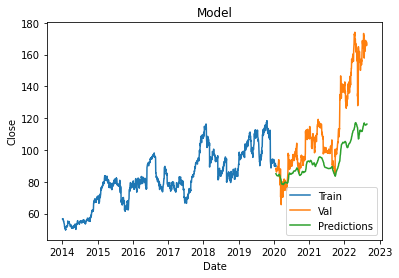

In [54]:
#Predict and visualize 

train = dltr_df[:training_data_len]

valid = dltr_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('Close')

plt.plot(train['Close'])

plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()


<AxesSubplot:xlabel='Date'>

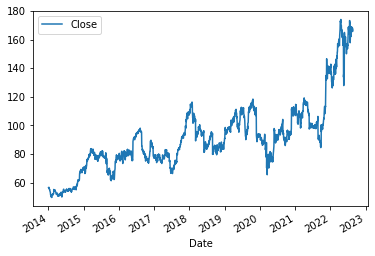

In [55]:
dltr_df.plot()

In [56]:
train['Close']

Date
2014-01-03    56.570000
2014-01-06    56.759998
2014-01-07    56.590000
2014-01-08    56.639999
2014-01-09    56.430000
                ...    
2020-01-15    90.750000
2020-01-16    91.080002
2020-01-17    91.550003
2020-01-21    89.500000
2020-01-22    89.870003
Name: Close, Length: 1523, dtype: float64

In [57]:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2020-01-23,87.940002,85.016075
2020-01-24,87.709999,84.896790
2020-01-27,88.400002,84.750671
2020-01-28,86.760002,84.610313
2020-01-29,86.110001,84.445778
...,...,...
2022-08-17,168.179993,115.934540
2022-08-18,168.050003,116.031403
2022-08-19,167.679993,116.133430


In [58]:
complete_df = pd.concat([train[['Close']], valid[['Close', 'Predictions']]])
complete_df

,Close,Predictions
Date,,
2014-01-03,56.570000,NaN
2014-01-06,56.759998,NaN
2014-01-07,56.590000,NaN
2014-01-08,56.639999,NaN
2014-01-09,56.430000,NaN
...,...,...
2022-08-17,168.179993,115.934540
2022-08-18,168.050003,116.031403
2022-08-19,167.679993,116.133430


In [59]:
complete_df.head()

,Close,Predictions
Date,,
2014-01-03,56.570000,NaN
2014-01-06,56.759998,NaN
2014-01-07,56.590000,NaN
2014-01-08,56.639999,NaN
2014-01-09,56.430000,NaN


In [60]:
complete_df2 = complete_df.dropna()

print(complete_df2)

                 Close  Predictions
Date                               
2020-01-23   87.940002    85.016075
2020-01-24   87.709999    84.896790
2020-01-27   88.400002    84.750671
2020-01-28   86.760002    84.610313
2020-01-29   86.110001    84.445778
...                ...          ...
2022-08-17  168.179993   115.934540
2022-08-18  168.050003   116.031403
2022-08-19  167.679993   116.133430
2022-08-22  167.419998   116.224792
2022-08-23  166.110001   116.298485

[652 rows x 2 columns]


In [61]:
complete_df2.to_csv('AP_DLTR.csv', index=False)